### a POD problem

POD tries to best approximate the solution trajectory but not the dynamics or the model that describes the dynamics. Nonetheless, POD is generally used as a method to approximate the actual model. 

This example shows a case, in which the POD model reduction totally fails in so far as the reduction leads to an unacceptable approximation error. In fact, for any grade of the POD reduction, the relative error is greater than 1, which means that the computed approximate solution is worse than just taking the zero function as approximant.

Furthermore

 * the *singular values* of the snapshot matrix nicely and quickly decay to machine precision `1e-16`, which is a common indicator for POD giving a suitable reduction
 * the principle that causes the failure is that the solution of the system $\dot x = Ax$ tends to a state $x^*$ that is in the kernel of $A$, e.g. $Ax^* = 0$. 
 * this potential problem might be less obvious but inherent in more general systems


In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
epsi = 1./100
tE = 2
Nts = 100                        # number of time points and snapshots
N = 10                           # dimension of the model will be 2*N
tmesh = np.linspace(0, tE, Nts)  # the time grid
discmodeslist = np.arange(2*N)   # number of modes to be discarded
inival = np.cos(np.linspace(0, 2*np.pi, 2*N))

In [3]:
scalevec = np.arange(N)
scaledeye = np.diag(scalevec)
# a simple Identity would do but this scaling gives a smoother decay of the singular values
nzero = np.zeros((N, N))
A = np.vstack([np.hstack([nzero, 1./epsi*scaledeye]),
               np.hstack([nzero, -epsi*scaledeye])])
def rhs(vvec, t):
    return A.dot(vvec).flatten()

In [4]:
soltrajec = odeint(rhs, inival, tmesh)
V, dg, _ = np.linalg.svd(soltrajec.T)
nrmfulsol = np.linalg.norm(soltrajec)

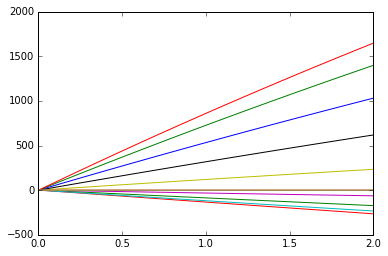

In [5]:
plt.close('all')
plt.figure(1)
plt.plot(tmesh, soltrajec)

### ### The Singular Values show a nice decay

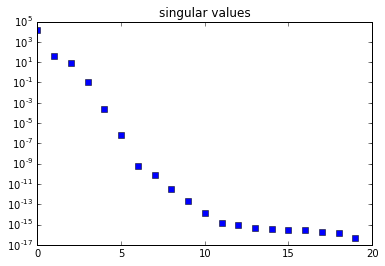

In [6]:
plt.figure(333)
plt.semilogy(dg, 's')
plt.title('singular values')

In [7]:
errlist = []
for discmodes in discmodeslist:
    k = 2*N - discmodes
    vone = V[0:k, :].T
    reda = vone.T.dot(A.dot(vone))
    redini = vone.T.dot(inival)
    def redrhs(vvec, t):
        return reda.dot(vvec).flatten()
    redsoltrajec = odeint(redrhs, redini, tmesh)
    infrdsol = vone.dot(redsoltrajec.T)
    diffsol = infrdsol - soltrajec.T
    nrmdifsol = np.linalg.norm(diffsol)
    relnrmdifsol = nrmdifsol/nrmfulsol
    errlist.append(relnrmdifsol)

### ### The approximation is bad 

Note that the relative error is larger than $1$ and shows no decay if more POD modes are included.

Only if the full basis is used, i.e. no reduction is performed, a useful estimation of the solution is obtained.

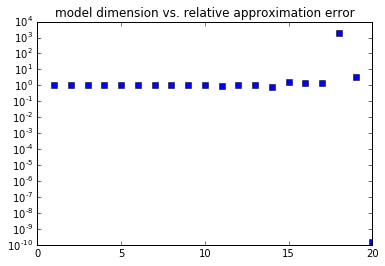

In [8]:
plt.figure(222)
plt.semilogy(2*N-np.array(discmodeslist), np.array(errlist), 's')
plt.title('model dimension vs. relative approximation error')
plt.show(block=False)

### what goes wrong here?

Concretely, we consider the ODE

$$
 \begin{bmatrix} I & 0 \\ 0 & I \end{bmatrix} 
 \begin{bmatrix} \dot x_1 \\  \dot x_2 \end{bmatrix} 
	 =
	 \begin{bmatrix} 0 & \frac{1}{\varepsilon}I \\ 0 & -\varepsilon I \end{bmatrix} 
 \begin{bmatrix} x_1 \\  x_2 \end{bmatrix} ,
     \quad 
     \begin{bmatrix} x_1(0) \\  x_2(0) \end{bmatrix}
     = 
     \begin{bmatrix} x_1^0 \\  x_2^0 \end{bmatrix}
$$
with an $\varepsilon > 0$. For any initial value, the solution component $x_2$ converges to zero exponentially, as can be read off from the second row $\dot x_2 = -\epsilon x_2$. The first equation, $\dot x_1 = \frac{1}{\epsilon}x_2$, says that the growth of $x_1$ is proportional to $x_2$, which means that $x_1$ will approach a constant level $x_1^*$ as time goes by (and as $x_2 \to 0$).

The snapshot matrix of such a trajectory will, thus, be of the form
$$
 Y = 
 \begin{bmatrix} x_1^{\mathsf{0}} &x_1^{\mathsf{1}} & \dots &x_1^{\mathsf{Nts}} 
	 \\ 					 x_2^{\mathsf{0}} &x_2^{\mathsf{1}} & \dots &x_2^{\mathsf{Nts}} \end{bmatrix} 
$$
and, more or less, close too
$$
 Y \approx 
 \begin{bmatrix} x_1^{\mathsf{0}} &x_1^{*} &x_1^{*} & \dots &x_1^{*} 
	 \\ 					 x_2^{\mathsf{0}} & 0 & 0 & \dots & 0 \end{bmatrix} ,
$$
(since the components approach their constant levels).

Since the left singular values of $Y$ try to best approximate the columns of $Y$, the matrix $V_k$ that consists of the $k$ most dominant singular vectors will approximately look like
$$
 V_k = 
 \begin{bmatrix} {v_1}_k \\  {v_2}_k \end{bmatrix} 
 \approx 
 \begin{bmatrix} v_1^{\mathsf{1}} &v_1^{\mathsf{2}} & \dots &v_1^{k} 
	 \\ 					 0 & 0 & \dots & 0 \end{bmatrix} .
$$

If now the model is projected by means of this basis, the reduced dynamics are 
$$
 \begin{bmatrix} {v_1}_k^T &  {v_2}_k^T \end{bmatrix} 
	 \begin{bmatrix} 0 & \frac{1}{\varepsilon}I \\ 0 & -\varepsilon I \end{bmatrix} 
 \begin{bmatrix} {v_1}_k \\  {v_2}_k \end{bmatrix} 
	 \approx
 \begin{bmatrix} {v_1}_k^T & 0 \end{bmatrix} 
	 \begin{bmatrix} 0 & \frac{1}{\varepsilon}I \\ 0 & -\varepsilon I \end{bmatrix} 
 \begin{bmatrix} {v_1}_k \\ 0 \end{bmatrix} 
	 =
     \begin{bmatrix} 0 \end{bmatrix},
$$
which shows that, in such a situation, more or less, all information of the dynamics are lost during the reduction. 

Even worse, the actual model was stable, while the reduced model is not exactly zero and, in general, unstable. Thus, the approximation error can become arbitrarily large.
